# Transcriptomic Clustering

In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import transcriptomic_clustering as tc 

## Loading data
- Operate on Annotated Data from scanpy/anndata. 
- Supports both dense sparse matrices
- Stored as an HDF5 file
- Allowing for both in-memory and file-backed operation

In [2]:
tasic_adata = sc.read_h5ad('./data/tasic2016counts_sparse.h5ad', backed='r')
print(tasic_adata)
print(tasic_adata.X)

AnnData object with n_obs × n_vars = 1809 × 24057 backed at 'data/tasic2016counts_sparse.h5ad'
<HDF5 sparse dataset: format 'csr', shape (1809, 24057), type '<f4'>


## Preprocessing: 
### Normalize data
- Normalize gene expression counts for each cell to sum to 1 million
- File-backed data supports chunking, but is turned off by default

In [4]:
normalized_adata = tc.normalize(tasic_adata,copy_to='./data/normalized4.h5ad')
print(normalized_adata)


processing: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

AnnData object with n_obs × n_vars = 1809 × 24057 backed at 'data/normalized4.h5ad'


### Normalize data (chunked)


In [5]:
tc.memory.get_available_system_memory_GB()

3.620655059814453

In [6]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           15Gi        10Gi       504Mi       1.3Gi       4.7Gi       3.6Gi
Swap:         2.0Gi       1.5Gi       545Mi


In [7]:
tc.memory.set_memory_limit(GB=0.4)
tc.memory.get_available_memory_GB()


0.04756774902343752

In [8]:
tc.memory.allow_chunking = True
normalized_adata = tc.normalize(tasic_adata,copy_to='./data/normalized10.h5ad')
print(normalized_adata)


processing: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]

AnnData object with n_obs × n_vars = 1809 × 24057 backed at 'data/normalized10.h5ad'


In [21]:
# if wanting to work with a subset of data in backed mode (here choosing the first 1000 cells):
normalized_adata = normalized_adata[:1000,:].copy(filename='./data/normalized_subset.h5ad')
print(normalized_adata)

AnnData object with n_obs × n_vars = 999 × 24057 backed at 'data/normalized_subset.h5ad'
    var: 'highly_variable'
    uns: 'hvg'


## Dimensionality reduction:
### 1. Find Highly Variant Genes
- Find highly variable genes to reduce the dimensionality by including only the informative genes. 
- Only these genes will be used for the subsequent dimensionality reduction and clustering.

In [18]:
means, variances, gene_mask = tc.get_means_vars_genes(adata=normalized_adata)
tc.highly_variable_genes(adata=normalized_adata, 
                         means=means, variances=variances, 
                         gene_mask=gene_mask, max_genes=3000)
print(normalized_adata)

AnnData object with n_obs × n_vars = 999 × 24057 backed at 'data/normalized_subset.h5ad'
    var: 'highly_variable'
    uns: 'hvg'


### 2. Find Principal Component Subspace

In [19]:
(components, explained_variance_ratio, explained_variance, means) = \
    tc.pca(normalized_adata, n_comps=25, cell_select=1000, use_highly_variable=True, svd_solver='arpack')
print(components.shape)

2021-07-23 16:19:25,832 root         WARNING  Ignoring svd_solver, using IncrementalPCA


(3000, 25)


### 3. Filter Known Modes (optional)
- removes some technical/experimental artifacts (dimensions)


In [39]:
known_artifacts = components[[24]] # select last component as a known mode as an example
components = tc.filter_known_modes(components, known_artifacts)
print(components.shape)

(3000, 24)


### 4. Projecting data onto the principla subspace

In [40]:
projected_adata = tc.project(normalized_adata, components, means)
print(projected_adata)

AnnData object with n_obs × n_vars = 1809 × 24


/home/sergeyg/repos/anndata/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Clustering
- Compute k nearest neighbour adjacency graph on each cell in the reduced space
- Louvain clustering method that optimizes modularity of communities
- Good performance
- Reproducible results

In [48]:
cluster_by_obs, obs_by_cluster, graph, qc = tc.cluster_louvain(projected_adata, k=10, n_jobs=8,random_seed=12341)

cluster_sizes_before_merging = {k: len(v) for k, v in obs_by_cluster.items()}
cluster_sizes_before_merging

100%|██████████| 1809/1809 [00:00<00:00, 26255.13it/s]


{0: 114,
 5: 256,
 1: 105,
 3: 122,
 6: 102,
 10: 28,
 11: 45,
 13: 77,
 14: 105,
 15: 41,
 12: 77,
 18: 75,
 19: 132,
 20: 30,
 21: 39,
 22: 38,
 16: 96,
 17: 72,
 24: 24,
 25: 13,
 2: 39,
 23: 64,
 9: 13,
 7: 12,
 4: 77,
 8: 13}

## Merging similar clusters 
- merge very small clusters with most correlated cluster
- merge cluster if differential expression score with neighbour clusters is below threshold

In [43]:
thresholds = {
    'q1_thresh': 0.5,
    'q2_thresh': None,
    'cluster_size_thresh': 15,
    'qdiff_thresh': 0.7,
    'padj_thresh': 0.05,
    'lfc_thresh': 1.0,
    'score_thresh': 200,
    'low_thresh': 1
}


cluster_assignments_after_merging = tc.merge_clusters(
    adata_norm=normalized_adata,
    adata_reduced=projected_adata,
    cluster_assignments=obs_by_cluster,
    cluster_by_obs=cluster_by_obs,
    thresholds=thresholds,
    de_method='ebayes'
)

2021-07-14 23:46:16,022 root         INFO     Merging small cluster 25 into 16 -- similarity: 0.8513873965850381
2021-07-14 23:46:16,034 root         INFO     Merging small cluster 7 into 4 -- similarity: 0.8103240276364321
2021-07-14 23:46:16,043 root         INFO     Merging small cluster 8 into 19 -- similarity: 0.724398432465724
2021-07-14 23:46:16,054 root         INFO     Merging small cluster 9 into 11 -- similarity: 0.48573515300341036
/home/sergeyg/repos/transcriptomic_clustering/transcriptomic_clustering/de_ebayes.py:111: UserWarning: offsetting zero variances from zero
  warnings.warn(f'offsetting zero variances from zero')
2021-07-14 23:47:00,935 root         INFO     Merging cluster 18 into 6 -- de score: 159.71203057121218
/home/sergeyg/repos/transcriptomic_clustering/transcriptomic_clustering/de_ebayes.py:111: UserWarning: offsetting zero variances from zero
  warnings.warn(f'offsetting zero variances from zero')


## Hierarchical Sorting

In [46]:
import numpy as np
cluster_by_obs_after_merging = np.zeros(len(cluster_by_obs), dtype=int)
for cluster, obs in cluster_assignments_after_merging.items():
    cluster_by_obs_after_merging[obs] = cluster
cluster_means, _, _ = tc.get_cluster_means(projected_adata, cluster_assignments_after_merging, cluster_by_obs_after_merging)
linkage, labels = tc.hclust(cluster_means)

## Display clustering dendrogram

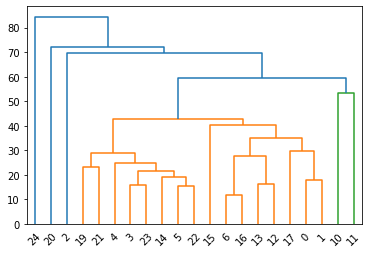

In [47]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
fig = plt.figure()
dendrogram(linkage, labels=labels)
plt.show()